## Imports

In [17]:
import numpy as np
import numpyro
from numpyro import distributions as dist
from numpyro.infer import MCMC, HMC, Predictive
from numpyro.infer.initialization import init_to_value

import jax
from jax import random, vmap
import jax.numpy as jnp
from jax.nn import relu

display(jax.devices())

import pickle

from src.models.NumPyroModels import NumPyroModel
from src.data_gens.TurbulenceClosureDataGenerator import TurbulenceClosureDataGenerator
from src.utils.plot_utils import plot_data_generation_diff, plot_heat_map_compare, plot_heat_map_loss, plot_heat_map_3D
from src.utils.data_utils import *


%load_ext autoreload
%autoreload 2

%matplotlib inline

[cuda(id=0)]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Creating Data Set

/home/codygrogan/PythonProjects/Uncertainty_Quantification/src/data_gens/TurbulenceClosureDataGenerator.py:88: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos((-b/2)/np.sqrt(-a**3/27))


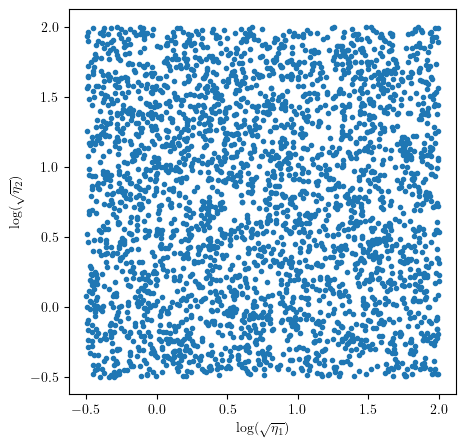

In [18]:
# Data generators for the different turbulence closures
SSG_gen = TurbulenceClosureDataGenerator('SSG')

# Defining the ranges for the different scales
log = (-.5, 2.0)

# Defining whether to exclude certain areas of the data
exclude_area = False
include_area = False
drop_eta_1 = False
drop_eta_2 = False
add_noise = False

# Defining area to exclude datapoints
eta_1_range = (10**np.array([-.3, 0.0]))**2
eta_2_range = (10**np.array([-.3, 0.0]))**2

etas_train, gs_train = generate_log_data(SSG_gen, log, 3_000, shuffle=True, gen_type="All")

etas_test, gs_test = generate_log_data(SSG_gen, log, 600, shuffle=True, gen_type="All")

if not drop_eta_1 and not drop_eta_2:
    plot_data_generation_diff(etas_train)

## Scaling Data and Converting

In [19]:
x_scaler = CustomScalerX().fit(etas_train)
y_scaler = CustomScalerY().fit(gs_train)

x_scaled_train = x_scaler.transform(etas_train)
y_scaled_train = y_scaler.transform(gs_train)

x_scaled_test = x_scaler.transform(etas_test)
y_scaled_test = y_scaler.transform(gs_test)

x_train = jnp.array(x_scaled_train, dtype=jnp.float32)
y_train = jnp.array(y_scaled_train, dtype=jnp.float32)

## Network and HMC parameters

In [29]:
hmc_checkpoints = "Model_Checkpoints/HMC/"

net_params = {
    "input_dim": 2,
    "output_dim": 3,
    "hidden_dim": 20,
    "num_layers": 4,
    "data_size": len(x_train),
    "layer_prior_scale": 5.0,
}

sampler_params = {
    "num_warmup": 4,
    "num_samples": 1,
    "num_chains": 3
}

#gold_step_size = 55e-5
#gold_trajectory_length = 1.6501

step_size = 50e-5
trajectory_length = 2.501
num_steps = int(np.ceil(trajectory_length // step_size))
print("Number of Steps: ", num_steps)

init_dict = pickle.load(open(hmc_checkpoints+"HMC_Initialize_large.pkl", "rb"))

for key, value in init_dict.items():
    print(key)
    init_dict[key] = jnp.array(value.T)
    print(init_dict[key].shape)

Number of Steps:  5001
w1
(2, 20)
b1
(20,)
w2
(20, 20)
b2
(20,)
w3
(20, 20)
b3
(20,)
w4
(20, 3)
b4
(3,)


## Run Training

In [30]:
from jax._src.nn.functions import relu
net = NumPyroModel(**net_params)

print(net._layer_tuples)

kernel = HMC(net, step_size=step_size, trajectory_length=trajectory_length, adapt_step_size=False, dense_mass=True, init_strategy=init_to_value(values=init_dict))

mcmc = MCMC(kernel, **sampler_params)

rng_key = random.PRNGKey(0)

mcmc.run(rng_key, x_train, y_train)

/tmp/ipykernel_97512/905476479.py:8: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, **sampler_params)


[(2, 20), (20, 20), (20, 20), (20, 3)]


sample: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it, 5002 steps of size 5.00e-04. acc. prob=0.00]


## Saving MCMC Run

In [31]:
save_dir = f"HMC_{sampler_params['num_warmup']}_{sampler_params['num_samples']}_{num_steps}.pkl"

def save_numpyro_mcmc(mcmc, save_dir):
    mcmc.sampler= None
    pickle.dump(mcmc, open(save_dir, "wb"))

save_numpyro_mcmc(mcmc, hmc_checkpoints+save_dir)

## Loading MCMC Run

In [32]:
def load_numpyro_mcmc(save_dir):
    return pickle.load(open(save_dir, "rb"))

mcmc_test = load_numpyro_mcmc(hmc_checkpoints+save_dir)
sampler = HMC(net, step_size=step_size, trajectory_length=trajectory_length, adapt_step_size=False, dense_mass=True, init_strategy=init_to_value(values=init_dict))
mcmc_test.sampler = sampler

mcmc_test.post_warmup_state = mcmc.last_state
mcmc_test.run(rng_key, x_train, y_train)

sample: 100%|██████████| 1/1 [00:01<00:00,  1.27s/it, 5002 steps of size 5.00e-04. acc. prob=0.00]
